<a href="https://colab.research.google.com/github/lucasjirwin/Meta-Learning-aspiration-RL-agent/blob/main/Thesis_Training_Reward_Functions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
pip install bayesian-optimization

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 25
        self.width = 25
        self.grid = np.zeros(( self.height, self.width)) - 1
        
        # Set random start location for the agent
        self.current_location = (24, np.random.randint(1,24))
        
        # Set locations for the bomb and the gold
        self.bomb_locations = [(0,12), (10,12), (11,12),(12,10),(12,11),(12,12),(12,13),(12,14),(13,12),(14,12),(24,12)]
        # self.gold_locations = [(0,6)(6,6)]
        self.gold_locations = [( np.random.choice([0,24]), np.random.choice([0,24]))]
        self.terminal_states = self.bomb_locations + self.gold_locations 
        
        # Set grid rewards for special cells
        for bomb_location in self.bomb_locations:
          self.grid[bomb_location[0],bomb_location[1]] = -10

        for gold_location in self.gold_locations:
          self.grid[gold_location[0],gold_location[1]] = 10
        
        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
        
    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions
    
    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid
    
    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]
        
    
    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location
        
        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
        
        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)
            
        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)
                
        return reward
    
    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0, alpha=0.1, gamma=0.99, aspiration = 0, weight_1 = 1, weight_2 = 1, weight_alpha = 1, weight_beta=1, weight_lambda = 1, use_aspiration = True):
        self.environment = environment
        self.q_table = dict() # Store all Q-values in dictionary of dictionaries 
        for x in range(environment.height): # Loop through all possible grid spaces, create sub-dictionary for each
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0} # Populate sub-dictionary with zero values for possible moves

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.aspiration = aspiration
        self.weight_1 = weight_1
        self.weight_2 = weight_2
        self.weight_alpha = weight_alpha
        self.weight_beta = weight_beta
        self.weight_lambda = weight_lambda
        self.use_aspiration = use_aspiration
        
    def choose_action(self, available_actions):
        """Returns the optimal action from Q-Value table. If multiple optimal actions, chooses random choice.
        Will make an exploratory random action dependent on epsilon."""
        if np.random.uniform(0,1) < self.epsilon:
            action = available_actions[np.random.randint(0, len(available_actions))]
        else:
            q_values_of_state = self.q_table[self.environment.current_location]
            maxValue = max(q_values_of_state.values())
            action = np.random.choice([k for k, v in q_values_of_state.items() if v == maxValue])
        
        return action
    
    def get_aspiration(self, reward):
      return (self.weight_1 * reward) + (self.weight_2 * (reward - self.aspiration))

    def get_value_function(self, reward):
      if (reward >= 0):
        return (reward)**(self.weight_alpha)
      else:
        return -self.weight_lambda * (-reward)**self.weight_beta
  
    def learn(self, old_state, reward, new_state, action):
      """Updates the Q-value table using Q-learning"""
      q_values_of_state = self.q_table[new_state]
      max_q_value_in_new_state = max(q_values_of_state.values())
      current_q_value = self.q_table[old_state][action]
      if self.use_aspiration:
        reward = self.get_aspiration(reward)
      else:
        reward = self.get_value_function(reward)
      self.q_table[old_state][action] = (1 - self.alpha) * current_q_value + self.alpha * (reward + self.gamma * max_q_value_in_new_state)


In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log
    
    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions) 
            reward = environment.make_step(action)
            new_state = environment.current_location
            
            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)
                
            cumulative_reward += reward
            step += 1
            
            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True     
                
        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log
        
    return reward_per_episode # Return performance log

# Testing Epsilon 

In [ ]:
from bayes_opt import BayesianOptimization

In [ ]:
def optimize(weight_alpha, weight_beta, weight_lambda):
    """
    implements function to optimize parameters for a Q-learning agent  
    """
    environment = GridWorld()
    agent = Q_Agent(environment,weight_alpha = weight_alpha, weight_beta = weight_beta,
                    weight_lambda = weight_lambda, use_aspiration= False)
    reward_per_episode = play(environment, agent, learn = True)
    return np.mean(reward_per_episode[200:])

In [ ]:
hyperparameter_bounds = {
    'weight_alpha': (0,1),
    'weight_beta': (1,3),
    'weight_lambda': (0,5)
}


# Initialize the optimizer and begin the search
optimizer = BayesianOptimization(
    f=optimize,
    pbounds=hyperparameter_bounds,
    verbose=2,
    allow_duplicate_points=True
)
optimizer.maximize(n_iter=100, allow_duplicate_points=True)

|   iter    |  target   | weight... | weight... | weight... |
-------------------------------------------------------------


<ipython-input-111-1425f3d0d862>:15: DeprecationWarning: 
Passing acquisition function parameters or gaussian process parameters to maximize
is no longer supported, and will cause an error in future releases. Instead,
please use the "set_gp_params" method to set the gp params, and pass an instance
 of bayes_opt.util.UtilityFunction using the acquisition_function argument

  optimizer.maximize(n_iter=100, allow_duplicate_points=True)


| 1         | -606.6    | 0.9669    | 1.36      | 3.592     |
| 2         | -737.3    | 0.5468    | 2.769     | 3.604     |
| 3         | -633.2    | 0.121     | 1.481     | 4.527     |
| 4         | -622.2    | 0.8125    | 1.452     | 3.249     |
| 5         | -744.1    | 0.6828    | 2.933     | 4.382     |
| 6         | -351.0    | 1.0       | 1.0       | 0.2808    |
| 7         | -1e+03    | 0.0       | 1.0       | 0.0       |
| 8         | -351.9    | 1.0       | 1.0       | 0.5882    |
| 9         | -687.8    | 1.0       | 1.63      | 0.485     |
| 10        | -361.4    | 1.0       | 1.0       | 1.164     |
| 11        | -354.0    | 1.0       | 1.0       | 1.882     |
| 12        | -358.4    | 0.2134    | 1.0       | 1.831     |
| 13        | -668.6    | 0.4999    | 1.798     | 1.918     |
| 14        | -350.2    | 0.0       | 1.0       | 2.562     |
| 15        | -361.8    | 1.0       | 1.0       | 5.0       |
| 16        | -739.6    | 0.01054   | 2.995     | 0.3776    |
| 17    

In [112]:
optimizer.max

{'target': -337.74666666666667,
 'params': {'weight_alpha': 0.0,
  'weight_beta': 1.0,
  'weight_lambda': 1.0201725541916435}}

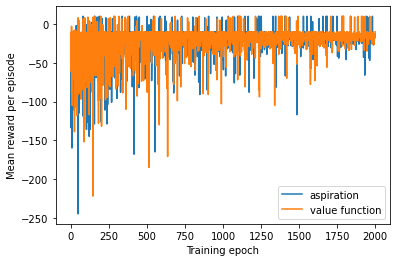

In [ ]:
# environment_1 = GridWorld()
# agent_1 = Q_Agent(environment_1, epsilon = 0.1)

# reward_per_episode_1 = play(environment_1, agent_1, learn = True, trials = 2000) # Fix reward per episode
# # for i in range(49):
# #  reward_per_episode_1 = [sum(x) for x in zip(reward_per_episode_1, play(environment_1, agent_1, learn = True))]

# # reward_per_episode_1 = [x/50 for x in reward_per_episode_1] 
# plt.plot(reward_per_episode_1, label = "epsilon")

environment_2 = GridWorld()
agent_2 = Q_Agent(environment_2, aspiration = 86.22432654685159, weight_1 = 0.0, weight_2 = 1.0)

reward_per_episode =play(environment_2, agent_2, learn = True, trials = 2000)
# for i in range(49):
#  reward_per_episode = [sum(x) for x in zip(reward_per_episode,play(environment_2, agent_2, learn = True))]

# reward_per_episode = [x/50 for x in reward_per_episode] 
plt.plot(reward_per_episode, label = "aspiration")


environment_3 = GridWorld()
agent_3 = Q_Agent(environment_3, aspiration = 2.222445733200897,
weight_1 = 0.0014073087193225975, use_aspiration=False)

reward_per_episode_3 = play(environment_3, agent_3, learn = True, trials = 2000)
# for i in range(49):
#  reward_per_episode_3 = [sum(x) for x in zip(reward_per_episode_3, play(environment_3, agent_3, learn = True))]

# reward_per_episode_3 = [x/50 for x in reward_per_episode_3] 
plt.plot(reward_per_episode_3, label ="value function")

plt.xlabel("Training epoch")
plt.ylabel("Mean reward per episode")
plt.legend()
plt.show()

[[3.0, -306.0, -312.0, -451.0, -90.0, -202.0, -684.0, -25.0, -192.0, -4.0, -117.0, -299.0, -166.0, -100.0, -1000.0, -279.0, -162.0, -170.0, -641.0, -373.0, -49.0, -536.0, -116.0, -123.0, -276.0, -49.0, -192.0, -127.0, -516.0, -116.0, -99.0, -304.0, -542.0, -530.0, -200.0, -1000.0, -319.0, -720.0, -12.0, -763.0, -294.0, -466.0, -255.0, -431.0, -91.0, -1000.0, -310.0, -1000.0, -640.0, -1000.0, -51.0, -1000.0, -911.0, -220.0, -15.0, -53.0, -162.0, -31.0, -86.0, -1000.0, -351.0, -70.0, -753.0, -322.0, -789.0, -341.0, -781.0, -101.0, -24.0, -1000.0, -109.0, -24.0, -693.0, -359.0, -700.0, -368.0, -697.0, -571.0, -150.0, -238.0, -176.0, -187.0, -24.0, -623.0, -567.0, -305.0, -462.0, -436.0, -367.0, -52.0, -662.0, -431.0, -250.0, -345.0, -1000.0, -21.0, -381.0, -52.0, -123.0, -258.0, -395.0, -10.0, -1000.0, -772.0, -556.0, -1000.0, -217.0, -1000.0, -46.0, -61.0, -607.0, -15.0, -397.0, -15.0, -73.0, -421.0, -163.0, -322.0, -639.0, -206.0, -1000.0, -517.0, -554.0, -1000.0, -352.0, -97.0, -119.0,

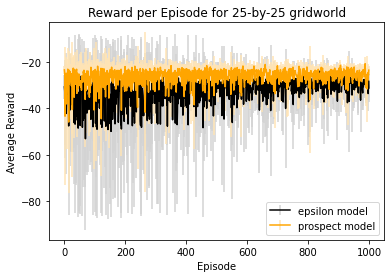

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem



# define a function to run the code for a given number of times
def run_experiment(num_trials, epsilon=0, aspiration=1, weight_1=1, weight_2=1,
                   weight_alpha=0, weight_beta=0, weight_lambda=0, use_aspiration=True):
   # define the environment and agent
    environment= GridWorld()
    agent = Q_Agent(environment, epsilon=epsilon, aspiration=aspiration, 
                    weight_1=weight_1, weight_2=weight_2, weight_alpha=weight_alpha, 
                    weight_beta=weight_beta, weight_lambda=weight_lambda, use_aspiration=use_aspiration)
    rewards = []
    for i in range(num_trials):
        reward_per_episode = play(environment, agent, learn=True, trials=1000, 
                                 )
        rewards.append(reward_per_episode)
    return rewards



# run the experiment 50 times and collect the rewards
num_experiments = 50
rewards_1 = run_experiment(50, epsilon = 0.1)
print(rewards_1)
# calculate the average and confidence intervals of the rewards
avg_rewards_1 = np.mean(rewards_1, axis= 0)
ci = sem(rewards_1, axis=0) * 1.96  # 95% confidence interval

# plot the results
plt.errorbar(np.arange(len(avg_rewards_1)), avg_rewards_1, yerr = ci, color='black',
             ecolor='lightgray', label="epsilon model" )

# num_experiments = 50
# rewards_2 = run_experiment(50, aspiration = 95.5678837426283, 
# weight_1 = 0.14334321777509418, weight_2 = 0.9790662405514902)
# # calculate the average and confidence intervals of the rewards
# print(rewards_2)
# avg_rewards_2 = np.mean(rewards_2, axis= 0)
# ci = sem(rewards_2, axis=0) * 1.96  # 95% confidence interval

# #plot the results
# plt.errorbar(np.arange(len(avg_rewards_2)), avg_rewards_2, yerr = ci, color='orange',
#              ecolor='moccasin',label ="aspiration model" )

num_experiments = 50
rewards_3 = run_experiment(50, weight_alpha= 0.0, weight_beta=0.0, 
                           weight_lambda = 4.670376634907947, use_aspiration=False)
# calculate the average and confidence intervals of the rewards
avg_rewards_3 = np.mean(rewards_3, axis= 0)
ci_3 = sem(rewards_3, axis=0) * 1.96  # 95% confidence interval

# plot the results
plt.errorbar(np.arange(len(avg_rewards_3)), avg_rewards_3, yerr = ci_3, color='orange',
             ecolor='moccasin', label="prospect model" )

plt.title("Reward per Episode for 25-by-25 gridworld")
plt.xlabel("Episode")
plt.ylabel("Average Reward") 
plt.legend(loc ='lower right')
plt.show()

In [118]:
np.sum(avg_rewards_1)/1000

-32.32698

In [119]:
np.sum(avg_rewards_1[:100])/100

-35.8214

In [120]:
np.sum(avg_rewards_1[:200])/200

-36.071299999999994

In [121]:
np.sum(avg_rewards_1[-100:])/100

-29.094199999999997

In [123]:
np.sum(avg_rewards_3)/1000

-26.42774

In [125]:
np.sum(avg_rewards_3[:100])/100

-28.241799999999998

In [126]:
np.sum(avg_rewards_3[:200])/200

-27.666299999999996

In [127]:
np.sum(avg_rewards_3[-100:])/100

-25.7854

[[-29.0, -76.0, -188.0, -108.0, -11.0, -83.0, 8.0, -132.0, -73.0, -68.0, -45.0, 6.0, -39.0, -21.0, -34.0, -41.0, -73.0, -11.0, -61.0, -17.0, -11.0, -26.0, 7.0, 4.0, -225.0, -31.0, -20.0, -14.0, -17.0, -33.0, 9.0, -27.0, -16.0, -134.0, -73.0, -11.0, -34.0, -138.0, -17.0, -19.0, -52.0, -52.0, -11.0, -26.0, -28.0, -10.0, -57.0, -69.0, -49.0, -38.0, -14.0, 10.0, -88.0, -64.0, -10.0, -10.0, -71.0, -11.0, -116.0, -30.0, -22.0, -16.0, -31.0, -25.0, -86.0, -36.0, -21.0, -53.0, -92.0, -40.0, -10.0, -66.0, -80.0, -40.0, -21.0, -16.0, -33.0, -31.0, -28.0, -19.0, -10.0, -77.0, -16.0, -11.0, -43.0, -2.0, -96.0, -38.0, 4.0, -10.0, -63.0, -75.0, -18.0, -27.0, -77.0, -45.0, -13.0, -20.0, -16.0, -10.0, -11.0, -36.0, -11.0, -36.0, -30.0, -13.0, -49.0, -10.0, -59.0, -42.0, 9.0, -13.0, -138.0, -75.0, -67.0, -12.0, -33.0, -13.0, -38.0, -12.0, -38.0, -31.0, -11.0, -11.0, -111.0, -24.0, -17.0, -19.0, -138.0, -4.0, -16.0, -114.0, -27.0, -11.0, -13.0, -25.0, -15.0, -12.0, -35.0, -67.0, -79.0, -55.0, -14.0, -25

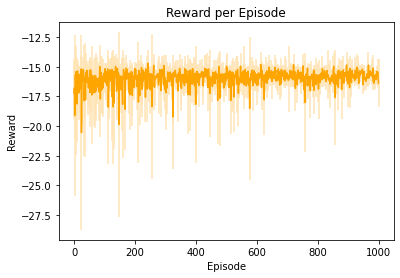

In [ ]:
# run the experiment 50 times and collect the rewards
num_experiments = 50
rewards_2 = run_experiment(50, aspiration = 86.22432654685159, weight_1 = 0.0, weight_2 = 1.0)
# calculate the average and confidence intervals of the rewards
print(rewards_2)
avg_rewards_2 = np.mean(rewards_2, axis= 0)
ci = sem(rewards_2, axis=0) * 1.96  # 95% confidence interval

# plot the results
plt.errorbar(np.arange(len(avg_rewards_2)), avg_rewards_2, yerr = ci, color='orange',
             ecolor='moccasin' )


plt.title("Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Reward") 
plt.show()

<ErrorbarContainer object of 3 artists>

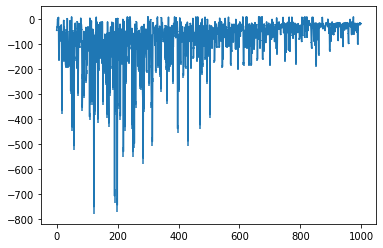

In [ ]:
plt.errorbar(np.arange(len(avg_rewards)), rewards[0], yerr=ci)

In [ ]:
print(np.mean(reward_per_episode[:100]))
print(np.mean(reward_per_episode_3[:100]))
# print(np.mean(reward_per_episode3))

# add error bars for average 
# run 50 agents, store the runs, average and plot and get error bars 

-43.43
-40.4


In [ ]:
# bomb locations: [(0,3),(3,2),(3,3),(3,4),(2,3),(4,3)]
# gold location randomly (0,0), (0,6), (6,0), (6,6)
# p = 75.88569095297652
# -13.844 p = 0 (first 200 episodes)
# -13.0808 p =75.88569095297652 (first 200 episodes)

In [ ]:
# 7x7
# bomb locations: [(0,3),(3,2),(3,3),(3,4),(2,3),(4,3)]
# gold location randomly (0,0), (0,6), (6,0), (6,6)
# aspiration = 95.68826452647366, weight_1 =0.15226336556299713, weight_2 = 0.6647641808393802
# -13.7844 p = 0
# -13.0102 p =75.88569095297652

In [ ]:
 # 13x13 grid
 # bomb_locations: [(0,6),(4,6), (5,6),(6,4),(6,5),(6,6),(6,7),(6,8),(7,6),(8,6),(12,6)]
 # gold location randomly (0,0), (0,12), (12,0), (12,12)
 # aspiration = 86.22432654685159, weight_1 = 0.0, weight_2 = 1.0
 # -19.3334 p = 0
 # -16.3978 p = 86.22432654685159


 # Prospect Theory
 #weight_p= 0.0014073087193225975, factor_p = 2.222445733200897

In [ ]:
# 25x25 grid 
# self.bomb_locations = [(0,12), (10,12), (11,12),(12,10),(12,11),(12,12),(12,13),(12,14),(13,12),(14,12),(24,12)]
# self.gold_locations = [(0,0),(0,24),(24,0),(24,24)]
#'aspiration': 95.5678837426283,
#   'weight_1': 0.14334321777509418,
#   'weight_2': 0.9790662405514902}

# Prospect Theory 
# 'weight_alpha': 0.0,
  # 'weight_beta': 0.0,
  # 'weight_lambda': 4.670376634907947


  # 'weight_alpha': 1.0,
  # 'weight_beta': 0.1,
  # 'weight_lambda': 4.734107902509065

In [ ]:
# Bayesian optimizer
# 100 iterations
# 

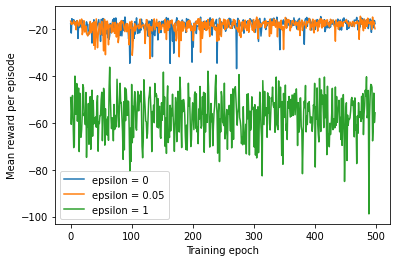

In [ ]:
environment_1 = GridWorld()
agent_1 = Q_Agent(environment_1, epsilon = 0)

reward_per_episode_1 = play(environment_1, agent_1, learn = True)
for i in range(49):
 reward_per_episode_1 = [sum(x) for x in zip(reward_per_episode_1,play(environment_1, agent_1, learn = True))]

reward_per_episode_1 = [x/50 for x in reward_per_episode_1] 
plt.plot(reward_per_episode_1, label = "epsilon = 0")

environment_2 = GridWorld()
agent_2 = Q_Agent(environment_2, epsilon = 0.05)

reward_per_episode =play(environment_2, agent_2, learn = True)
for i in range(49):
 reward_per_episode = [sum(x) for x in zip(reward_per_episode,play(environment_2, agent_2, learn = True))]

reward_per_episode = [x/50 for x in reward_per_episode] 
plt.plot(reward_per_episode, label = "epsilon = 0.05")


environment_3 = GridWorld()
agent_3 = Q_Agent(environment_3, epsilon = 1)

reward_per_episode_3 = play(environment_3, agent_3, learn = True)
for i in range(49):
 reward_per_episode_3 = [sum(x) for x in zip(reward_per_episode_3, play(environment_3, agent_3, learn = True))]

reward_per_episode_3 = [x/50 for x in reward_per_episode_3] 
plt.plot(reward_per_episode_3, label ="epsilon = 1")

plt.xlabel("Training epoch")
plt.ylabel("Mean reward per episode")
plt.legend()
plt.show()

In [ ]:
print(np.mean(reward_per_episode_1[:100]))
print(np.mean(reward_per_episode[:100]))
print(np.mean(reward_per_episode_3[:100]))


-19.234199999999998
-19.6234
-57.075
